In [1]:
from torchvision import models, transforms
from sess import SESS
from cam import GradCAM, CAM, GuidedBackProp, GroupCAM, ScoreCAM # import base visualiation methods
from utils import load_image, save_img_with_heatmap, check_path_exist, apply_transforms, save_heatmap
import time
import json
from utils import get_transform
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def get_ImageNet_classes():
    """
        Load imagenet labels.
    """
    LABELS_file = 'utils/resources/imagenet_class_index.json'
    with open(LABELS_file, 'r') as f:
        class_ids =json.load(f)
    return class_ids

def saliency_visualisation(img, saliency):
    fig, ax = plt.subplots(1,2)
    img_heatmap = save_img_with_heatmap(img, saliency, None, style='zhou', normalise=True)
    # plt.imshow((img_heatmap[:, :, ::-1]).astype(np.uint8))
    ax[0].imshow((img_heatmap[:, :, ::-1]).astype(np.uint8))
    heatmap = save_heatmap(saliency, None, normalise=True)
    ax[1].imshow((heatmap[:, :, ::-1]).astype(np.uint8))

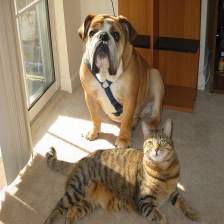

In [3]:
# Load target iamge
image_file = 'examples/both.png' # More examples exist in the examples folder
img = load_image(image_file)
display(img)

In [4]:
# Model and base visualisation method initialisation
model = 'resnet50'
target_layer = 'layer4'
model = models.__dict__[model](pretrained=True).eval()
model = model.cuda()

In [5]:
target_class_id = 282 # When target class id is None, target class is the most activated class
class_ids = get_ImageNet_classes()
if target_class_id is not None:
    print('Current class label is', class_ids[str(target_class_id)][1])

Current class label is tiger_cat


# Grad-cam Vs Grad-cam with SESS

In [6]:
# Gradcam
gc = GradCAM(model, target_layer=target_layer)

In [7]:
transform = get_transform(resize_size=224, center_crop_size=None)
x = transform(img).unsqueeze(0)
start = time.time()
saliency, _ = gc(x, target_class_id)
print('Total time: {:.2f} second'.format((time.time()-start)))
saliency = cv2.resize(np.squeeze(saliency), img.size)
#print('Current class is ', class_ids[str(idx)][1])

Total time: 0.09 second


/home/osman/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/osman/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Saliency generated by Grad-CAM


error: OpenCV(4.5.5) /io/opencv/modules/imgcodecs/src/loadsave.cpp:730: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'


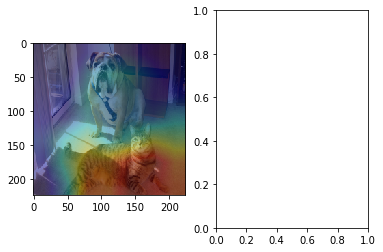

In [8]:
print('Saliency generated by Grad-CAM')
saliency_visualisation(img, saliency)

In [9]:
# Set SESS parameters
num_scales = 12
scales = [224 + 64 * i for i in range(num_scales)]
pre_filter_ratio = 0
theta = 0
step_size = 224
sess = SESS(gc, pre_filter_ratio=pre_filter_ratio, theta=theta, pool='mean',
            window_size=224, step_size=step_size, min_overlap_ratio=1, scales=scales,
            requires_grad=False, output=None, verbose=1, smooth=True)

In [10]:
transform = get_transform(resize_size=None, center_crop_size=None)
x = transform(img).unsqueeze(0)
start = time.time()
saliency, idx = sess(x, target_class_id)
print('Total time: {:.2f} second'.format((time.time()-start)))
saliency = cv2.resize(saliency, img.size)
print('Current class is ', class_ids[str(idx)][1])

Total number of all extracted patches:  122
Total number of remained patches: 122
Total number of channels:  122
Total time: 4.38 second
Current class is  tiger_cat


Saliency generated by Grad-CAM with SESS


error: OpenCV(4.5.5) /io/opencv/modules/imgcodecs/src/loadsave.cpp:730: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'


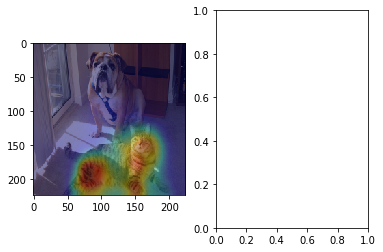

In [11]:
print('Saliency generated by Grad-CAM with SESS')
saliency_visualisation(img, saliency)

# GuidedBP vs GuidedBP with SESS

In [12]:
gp = GuidedBackProp(model)
transform = get_transform(resize_size=(224, 224), center_crop_size=None)
x = transform(img).unsqueeze(0)
x = transform(img).unsqueeze(0)
start = time.time()
saliency, _ = gp(x, target_class_id)
print('Total time: {:.2f} second'.format((time.time()-start)))

Total time: 0.04 second


Saliency generated by Guided Backpropagation


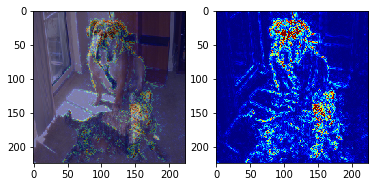

In [13]:
saliency = cv2.resize(np.squeeze(saliency), img.size)
print('Saliency generated by Guided Backpropagation')
saliency_visualisation(img, saliency)

In [14]:
# Set SESS parameters
num_scales = 12
scales = [224 + 64 * i for i in range(num_scales)]
pre_filter_ratio = 0
theta = 0
step_size = 224
sess = SESS(gp, pre_filter_ratio=pre_filter_ratio, theta=theta, pool='mean',
            window_size=224, step_size=step_size, min_overlap_ratio=1, scales=scales,
            requires_grad=False, output=None, verbose=1, smooth=True)

In [15]:
transform = get_transform(resize_size=None, center_crop_size=None)
x = transform(img).unsqueeze(0)
start = time.time()
saliency, idx = sess(x, target_class_id)
print('Total time: {:.2f} second'.format((time.time()-start)))
saliency = cv2.resize(saliency, img.size)
print('Current class is ', class_ids[str(idx)][1])

Total number of all extracted patches:  122
Total number of remained patches: 122
Total number of channels:  122
Total time: 4.31 second
Current class is  tiger_cat


Saliency generated by Guided Backpropagation with SESS


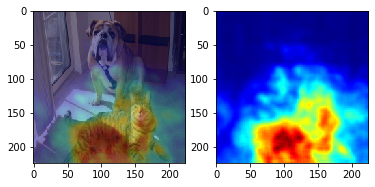

In [16]:
print('Saliency generated by Guided Backpropagation with SESS')
saliency_visualisation(img, saliency)

# Group-CAM vs Group-CAM with SESS

In [17]:
grc = GroupCAM(model, target_layer=target_layer)
transform = get_transform(resize_size=(224, 224), center_crop_size=None)
x = transform(img).unsqueeze(0)
x.requires_grad = True
start = time.time()
saliency, _ = grc(x.cuda(), target_class_id)
print('Total time: {:.2f} second'.format((time.time()-start)))

Total time: 0.15 second


Saliency generated by GroupCAM


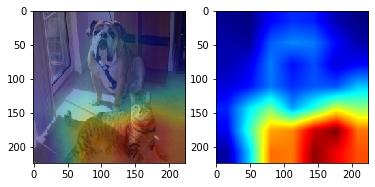

In [18]:
print('Saliency generated by GroupCAM')
saliency = np.squeeze(saliency)
saliency = cv2.resize(saliency, img.size)
saliency_visualisation(img, saliency)

In [19]:
# Set SESS parameters
num_scales = 12
scales = [224 + 64 * i for i in range(num_scales)]
pre_filter_ratio = 0
theta = 0
step_size = 224
sess = SESS(grc, pre_filter_ratio=pre_filter_ratio, theta=theta, pool='mean',
            window_size=224, step_size=step_size, min_overlap_ratio=1, scales=scales,
            requires_grad=False, output=None, verbose=1, smooth=True)

In [20]:
transform = get_transform(resize_size=None, center_crop_size=None)
x = transform(img).unsqueeze(0)
start = time.time()
saliency, idx = sess(x, target_class_id)
print('Total time: {:.2f} second'.format((time.time()-start)))
saliency = cv2.resize(saliency, img.size)
print('Current class is ', class_ids[str(idx)][1])

Total number of all extracted patches:  122
Total number of remained patches: 122
Total number of channels:  122
Total time: 17.19 second
Current class is  tiger_cat


Saliency generated by Group-CAM with SESS


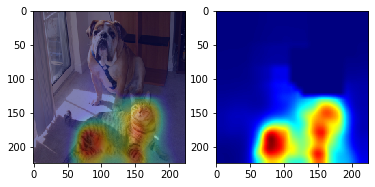

In [21]:
print('Saliency generated by Group-CAM with SESS')
saliency_visualisation(img, saliency)

In [22]:
# Score-CAM vs Group-CAM with SESS

In [23]:
sc = ScoreCAM(model, target_layer=target_layer)

In [24]:
transform = get_transform(resize_size=(224, 224), center_crop_size=None)
x = transform(img).unsqueeze(0)
start = time.time()
saliency, _ = sc(x.cuda(), target_class_id)
print('Total time: {:.2f} second'.format((time.time()-start)))

Total time: 12.44 second


Saliency generated by Score-CAM


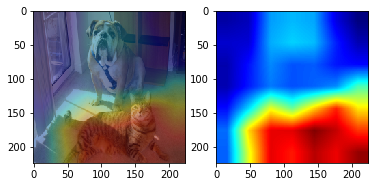

In [25]:
print('Saliency generated by Score-CAM')
saliency = np.squeeze(saliency)
saliency = cv2.resize(saliency, img.size)
saliency_visualisation(img, saliency)

In [26]:
# Set SESS parameters
# To efficiency, few sacles and high pre_filter_ration are applied
num_scales = 5
scales = [224 + 64 * i for i in range(num_scales)]
pre_filter_ratio = 0.5
theta = 0
step_size = 224
sess = SESS(sc, pre_filter_ratio=pre_filter_ratio, theta=theta, pool='mean',
            window_size=224, step_size=step_size, min_overlap_ratio=1, scales=scales,
            requires_grad=False, output=None, verbose=1, smooth=True)

In [ ]:
transform = get_transform(resize_size=224, center_crop_size=None)
x = transform(img).unsqueeze(0)
start = time.time()
saliency, idx = sess(x, target_class_id)
print('Total time: {:.2f} second'.format((time.time()-start)))
saliency = cv2.resize(saliency, img.size)
print('Current class is ', class_ids[str(idx)][1])

Saliency generated by Score-CAM with SESS


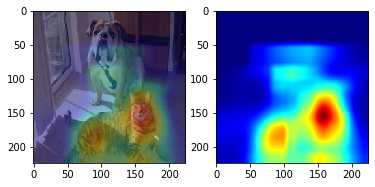

In [28]:
print('Saliency generated by Score-CAM with SESS')
saliency = np.squeeze(saliency)
saliency = cv2.resize(saliency, img.size)
saliency_visualisation(img, saliency)